In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "New KL Weight"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random

In [3]:
from tensorflow.keras.models import Model
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 256
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 200
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-5
# Good value: 1e-6

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "CVAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_training_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])
y_validation = np.asarray(hf_validation['specz_redshift'][0:])
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_validation.close()

In [8]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten)
dense2 = tf.keras.layers.Dense(32, activation = "relu")(redshifts)
dense3 = tf.keras.layers.Dense(32, activation = "relu")(dense2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

In [9]:
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)
reshape = Reshape((8 * LATENT_DIM, 32, 32))
conv3 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv4 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')
conv6 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')
outputs = Reshape(IMAGE_SHAPE)

In [10]:
dense5_model = dense5(zc)
reshape_model = reshape(dense5_model)
conv3_model = conv3(reshape_model)
conv4_model = conv4(conv3_model)
conv5_model = conv5(conv4_model)
conv6_model = conv6(conv5_model)
cropping_model = cropping(conv6_model)
outputs_model = outputs(cropping_model)

In [11]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])

In [12]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
reshape_decoder = reshape(dense5_decoder)
conv3_decoder = conv3(reshape_decoder)
conv4_decoder = conv4(conv3_decoder)
conv5_decoder = conv5(conv4_decoder)
conv6_decoder = conv6(conv5_decoder)
cropping_decoder = cropping(conv6_decoder)
outputs_decoder = outputs(cropping_decoder)

In [13]:
decoder = Model(latents, outputs_decoder)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 64, 64)    368         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 32, 32)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [15]:
model.compile(optimizer = 'adam', loss = 'mse')

In [16]:
run = neptune.init(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-100
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [66]:
history = model.fit(x = [x_train, y_train], y = x_train, epochs = EPOCHS, callbacks = [weights_callback, LR_callback, neptune_callback], validation_data = ([x_validation, y_validation], x_validation), verbose = 1)

Epoch 1/200
313/313 - 121s - loss: 0.1160 - val_loss: 0.1282
Epoch 2/200
313/313 - 97s - loss: 0.1158 - val_loss: 0.1324
Epoch 3/200
313/313 - 94s - loss: 0.1145 - val_loss: 0.1320
Epoch 4/200
313/313 - 105s - loss: 0.1154 - val_loss: 0.1305
Epoch 5/200
313/313 - 92s - loss: 0.1187 - val_loss: 0.1318
Epoch 6/200


KeyboardInterrupt: 

In [18]:
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', 'r')
x_test = np.asarray(hf_test['image'][0:])[0:10000]
x_test = np.true_divide(x_test, max_value)
y_test = np.asarray(hf_test['specz_redshift'][0:])[0:10000]
object_id = np.asarray(hf_test['object_id'][0:])[0:10000]
hf_test.close()

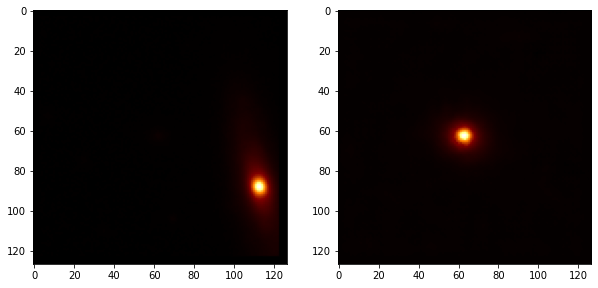

Redshift: 
0.343719989
Loss: 
0.006188949104398489


In [68]:
index = 105
z = y_test[index]
str = np.asarray(encoder([np.array([x_test[index]]), np.array([y_test[index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
loss = model.evaluate([np.array([x_test[index]]), np.array([y_test[index]])], np.array([x_test[index]]), verbose = 0)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(x_train[index][0], cmap = 'afmhot')
axes[1].imshow(decoder.predict([str])[0][0], cmap = 'afmhot')
plt.show()
print("Redshift: ")
print(z)
print("Loss: ")
print(loss)

In [20]:
for i in range(0, 10000):
    z = y_test[i]
    str = np.asarray(encoder([np.array([x_test[i]]), np.array([y_test[i]])])[0])
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    hdul = fits.PrimaryHDU(data = x_test[i])
    string = f"/data/CVAE Generated/Full/Original Galaxy #{i}.fits"
    hdul.writeto(string, overwrite = True)
    hdul = fits.PrimaryHDU(data = decoder([str])[0])
    string = f"/data/CVAE Generated/Full/Reconstructed Galaxy #{i}.fits"
    hdul.writeto(string, overwrite = True)

In [21]:
# END